# Structure learning in decomposable graphical models

## Gaussian graphical models (GGMs)

In [5]:
import numpy as np
import pandas as pd
import trilearn.smc as smc
import networkx as nx
import trilearn.graph.graph as glib
import matplotlib.pyplot as plt

np.random.seed(2)

Read (centralized around origo) data from file

In [6]:
df = pd.read_csv("sample_data/dataset_p15.csv", header=None)

For this tdaaset, the true underlying depencece structure can be loaded as:

In [7]:
true_graph = glib.from_json_file("sample_data/graph_p15.json")

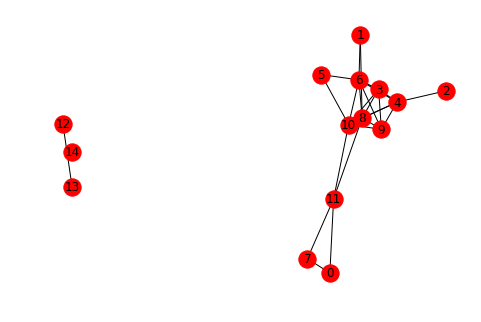

In [8]:
nx.draw(true_graph, with_labels=True)

In [9]:
df.shape

(100, 15)

In [10]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.268878,0.109906,-0.353295,-1.077679,-0.707938,-3.356246,-1.899697,-1.572408,-1.363449,0.387727,-1.100505,-0.583745,0.582096,0.332725,-1.072969
1,0.717418,0.889198,0.793387,1.966528,0.753154,-0.399547,0.531658,0.207708,0.779332,1.288162,0.215957,0.541811,0.309820,1.210676,0.042214
2,1.064512,1.587411,0.138867,0.363370,0.503868,1.193544,0.182134,-0.597229,0.219855,0.189130,0.921610,-0.414998,0.224087,0.966131,-0.845206


Generate particle Gibbs trajectory of graphs 

In [11]:
graph_traj = smc.gen_pgibbs_ggm_trajectory(dataframe=df, n_particles=50, n_samples=1000)

Particle Gibbs samples: 100%|██████████| 1000/1000 [12:11<00:00,  1.37it/s]


Inspect the likelihood, and the auto-correlation (on graph size) plots to determine the burn-in period

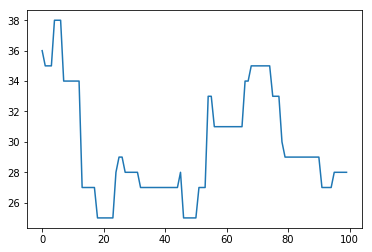

In [24]:
graph_traj.autocorrelation_size().plot()

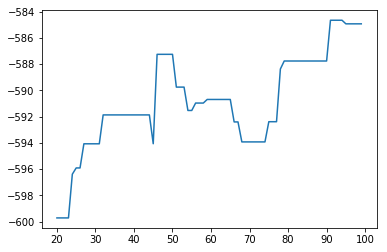

In [26]:
graph_traj.likelihood()[20:].plot()

Plot the heatmap based on the samples after the burnin period

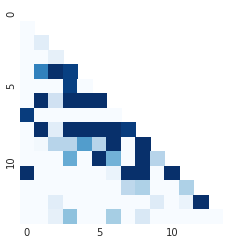

In [27]:
graph_traj.plot_heatmap(from_index=20)

In [35]:
mapgraph = graph_traj.empirical_distribution().mode()

In [36]:
mapgraph.edges

EdgeView([(0, 11), (0, 7), (1, 8), (1, 6), (2, 4), (3, 8), (3, 4), (3, 5), (3, 6), (4, 8), (4, 6), (5, 8), (5, 10), (5, 6), (6, 8), (6, 9), (6, 10), (7, 8), (7, 11), (7, 12), (8, 9), (8, 10), (8, 11), (8, 12), (10, 11), (11, 12), (12, 13)])

Create a nice visualization with matplotlib (any vizualization tool could be used here). 

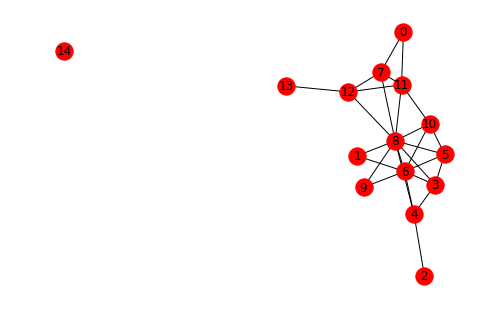

In [37]:
nx.draw(mapgraph, with_labels=True)

## Discrete log-linear models

Read data from file, where the first two rows, [0, 1], of the file should specify the labels and the levels of the corresponding variables. The outcomes are assumed to be 

In [3]:
df_discrete = pd.read_csv("sample_data/czech_autoworkers.csv", header=[0, 1])

In [4]:
df_discrete.shape

(1841, 6)

In [5]:
df_discrete.head(3)

,A,B,C,D,E,F
,2,2,2,2,2,2
0,1,1,1,0,0,0
1,1,1,1,0,0,0
2,1,1,1,0,0,0


Generate particle Gibbs trajectory of graphs

In [7]:
graph_traj_discrete = smc.gen_pgibbs_loglin_trajectory(dataframe=df_discrete, n_particles=50, n_samples=100)

Particle Gibbs samples: 100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


Inspect the likelihood and the auto-correlation (on graph size) plots to determine the burn-in period

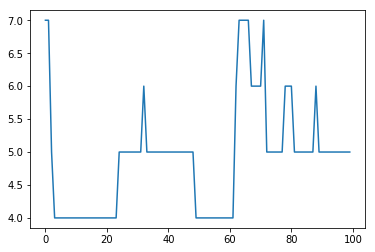

In [9]:
graph_traj_discrete.autocorrelation_size().plot()

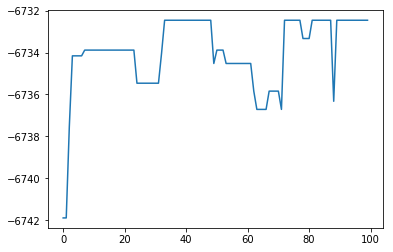

In [10]:
graph_traj_discrete.likelihood().plot()

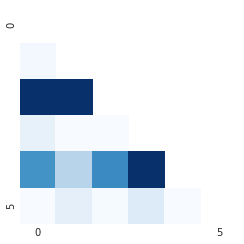

In [11]:
graph_traj_discrete.plot_heatmap(from_index=0)

Get the grpah with the highest posterior probability

In [38]:
mapgraph = graph_traj_discrete.empirical_distribution().mode()

In [39]:
mapgraph.nodes

NodeView((0, 1, 2, 3, 4, 5))

In [40]:
mapgraph.edges

EdgeView([(0, 2), (0, 4), (1, 2), (2, 4), (3, 4)])

Create an ugly visualization with matplotlib.

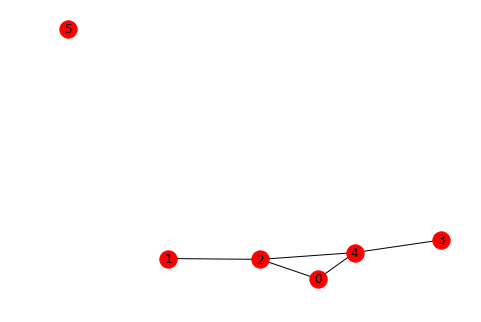

In [41]:
nx.draw(mapgraph, with_labels=True)

## Simulate junction trees and decomposable graphs

In [19]:
from trilearn.graph import junction_tree as jt

In [20]:
from trilearn.graph import junction_tree_collapser as jtcol, junction_tree_expander as jtexp

Sample a junction tree with the Christmas tree algorithm as

In [21]:
tree = jt.sample(internal_nodes=5)

In [22]:
tree.nodes

NodeView((frozenset([0, 1, 2, 3]), frozenset([0, 2, 4])))

In [23]:
tree.edges

EdgeView([(frozenset([0, 1, 2, 3]), frozenset([0, 2, 4]))])

Expand the tree by the vertex 5

In [24]:
exp_tree = jtexp.sample(tree, 5)

In [25]:
exp_tree.nodes

NodeView((frozenset([5]), frozenset([0, 1, 2, 3]), frozenset([0, 2, 4])))

In [26]:
exp_tree.edges

EdgeView([(frozenset([5]), frozenset([0, 2, 4])), (frozenset([0, 1, 2, 3]), frozenset([0, 2, 4]))])

Collapse the nex tree by the vertex 5

In [36]:
col_tree = jtcol.sample(exp_tree, 5)

In [37]:
col_tree.nodes

NodeView((frozenset([0, 1, 2, 3]), frozenset([0, 2, 4])))

Get the underlying decomposable graph

In [29]:
graph = tree.to_graph()

In [30]:
graph.nodes

NodeView((0, 1, 2, 3, 4))

In [31]:
graph.edges

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (2, 3), (2, 4)])

# Classification

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from trilearn.graph_predictive import GraphPredictive
from sklearn.model_selection import train_test_split
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "LDA", "QDA", "BayesPred", "GraphPred"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto'),
    QuadraticDiscriminantAnalysis(),
    GraphPredictive(standard_bayes=True),
    GraphPredictive(n_particles=100, n_pgibbs_samples=5)]



Read classification dataset and compare to the existing classifiers. BayesPred is the standard BAyesian predictive classifier and GraphPred is the graphical predicitve classifier. 

In [2]:
df_full = pd.read_csv("classification_full_dataset.csv")

x_train, x_test, y_train, y_test = train_test_split(df_full.drop(["y"], axis=1), df_full["y"],
                                                    test_size=0.3, random_state=1)
# Comparison
for name, clf in zip(names, classifiers):
    clf.fit(x_train.get_values(), y_train.get_values())
    print str(name) + " " + str(clf.score(x_test.get_values(),
                                          y_test.get_values()))




Nearest Neighbors 0.5238095238095238
Linear SVM 0.4523809523809524
RBF SVM 0.40476190476190477
Gaussian Process 0.5476190476190477
Decision Tree 0.5238095238095238
Random Forest 0.47619047619047616


/Users/felixwork/git/trilearn/env/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Neural Net 0.5952380952380952
AdaBoost 0.5952380952380952
Naive Bayes 0.6190476190476191
LDA 0.5476190476190477
QDA 0.7619047619047619


/Users/felixwork/git/trilearn/env/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
Particle Gibbs samples:   0%|          | 0/5 [00:00<?, ?it/s]

BayesPred 0.7619047619047619


Particle Gibbs samples: 100%|██████████| 5/5 [00:09<00:00,  1.99s/it]


GraphPred 0.8809523809523809


# Estimate the number of decomposable graphs

In [32]:
import trilearn.smc as smc

The following command estimates the number of decomopsable graphs

In [33]:
p = 20
n_graphs = smc.est_n_dec_graphs(p, n_particles=1000)
n_graphs

Const estimates: 100%|██████████| 1/1 [00:18<00:00, 18.06s/it]


array([1.00000000e+00, 2.00000000e+00, 7.92400000e+00, 5.87432533e+01,
       8.45215334e+02, 1.87678926e+04, 5.75827317e+05, 3.09019997e+07,
       2.05005539e+09, 2.18507988e+11, 2.96711710e+13, 4.99592550e+15,
       1.11350311e+18, 3.07365530e+20, 1.77348195e+23, 8.79418996e+25,
       5.43477633e+28, 4.43421648e+31, 5.82771541e+34, 8.16946103e+37])

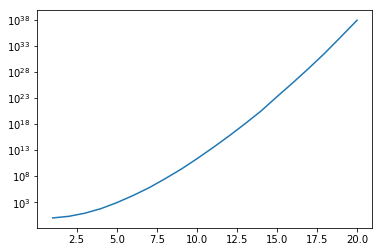

In [34]:
import matplotlib.pyplot as plt
plt.semilogy(range(1, p+1), n_graphs)